In [234]:
!pip install stockfish
import tensorflow as tf
import re
import chess
from stockfish import Stockfish
import numpy as np
import pandas as pd
import chess_funcs as chess_funcs
import random
import matplotlib.pyplot as plt

You should consider upgrading via the '/home/ada/pythonJupyter/jupyterenvironment/bin/python -m pip install --upgrade pip' command.


## Overview

The purpose of this notebook is to compare the recommendations provided by application against the ratings provided by stock fish.

The game data used here was taken from the FICS database for the year 2018.

## Read in Game Data and Model

In [2]:
def readFile(file_name):
    chess_list = []
    chess_game = {}
    with open(file_name) as f:
        for index, line in enumerate(f):
            
            line = line.strip()
            if len(line) == 0:
                continue
            if line[0] == '[':
                line = line.replace('[', '')
                line = line.replace(']', '')
                line = line.replace('"', '')
                
                key,value = line.split(' ', 1)
                chess_game[key] = value
            elif line[0] == '1':
                line = re.sub('\d*\.', ':', line).strip()
                chess_game['game'] = line.split(":")[1:]
                chess_list.append(chess_game)
                chess_game = {}
    return chess_list
chess_data = readFile('2018')
chess_data_cleaned = []
for game in chess_data:
    if len(game['Result']) == 3:
        chess_data_cleaned.append(game)
chess_list = chess_data_cleaned

Next proces the game data to be a list of game moves in UCI notation

In [3]:
game_stack = []
for game in chess_list:
    board = chess.Board()
    for turn in game['game']:
        if turn.find("{") != -1:
            continue
        turn = turn.strip()
        turn = turn.split(" ")
        if len(turn) > 1:
            board.push_san(turn[0])
            board.push_san(turn[1])
        elif len(turn) == 1:
            board.push_san(turn[0])
    game_stack.append(board.move_stack)

In [4]:
len(game_stack)

66393

## Instantiate Stockfish and ML Model

In [5]:
stockfish = Stockfish('/usr/games/stockfish')
stockfish = Stockfish(parameters={"Threads": 2, "Minimum Thinking Time": 30})
model = tf.keras.models.load_model('chess_10000_10_redux.h5')

Convert the UCI moves from a chess move object to a string. Both Chess and Stockfish understand strings containing UCI moves.

In [6]:
##convert games to text:
for x in range(0, len(game_stack)):
    for y in range(0, len(game_stack[x])):
        game_stack[x][y] = str(game_stack[x][y])

In [ ]:
performance = pd.DataFrame(columns=['pressure_cp',
                                    'ml_cp',
                                    'stockfish_cp',
                                    'stockfish1400_cp',
                                    'stockfish800_cp',
                                    'random_cp',
                                   'player'])
count = 0
for game in game_stack[0:(60*4)]:
    count +=1
    player = 'W'
    stockfish = Stockfish('/usr/games/stockfish')
    for move in range(0, len(game)):
        board = chess.Board()
        for step in range(0,move):
            board.push_uci(game[step])
        if move % 2 == 0:
            player = 'W'
        else:
            player = 'B'
        positions = chess_funcs.translate(str(board))
        if player == 'W':
            press, press_val, ml, ml_val = chess_funcs.recommend_white(chess_funcs.create_board_from_positions(positions), model)
        else:
            press, press_val, ml, ml_val = chess_funcs.recommend_black(chess_funcs.create_board_from_positions(positions), model)
        #print(move)
        #print(stockfish.get_best_move())
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move])
        best = stockfish.get_best_move()
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [best])
        #print(stockfish.get_board_visual())
        stockfish_recommendation_cp = stockfish.get_evaluation()['value']  
        #print(press)
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [press])
        #print(stockfish.get_board_visual())
        pressure_recommendation_cp = stockfish.get_evaluation()['value']
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [ml])
        #print(ml)
        #print(stockfish.get_board_visual())
        ml_recommendation_cp = stockfish.get_evaluation()['value']
        legal_moves = []
        for san in board.legal_moves:
            legal_moves.append(str(san))
        random_move = legal_moves[random.randint(0,len(legal_moves)-1)]
        #print(random_move)
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [str(random_move)])
        #print(stockfish.get_board_visual())
        random_cp = stockfish.get_evaluation()['value']

        stockfish1400 = Stockfish('/usr/games/stockfish')
        stockfish1400.set_elo_rating(1400)
        stockfish1400.set_position(game[0:move])
        best = stockfish1400.get_best_move()
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [best])
        stockfish1400_recommendation_cp = stockfish.get_evaluation()['value']  

        stockfish800 = Stockfish('/usr/games/stockfish')
        stockfish800.set_elo_rating(800)
        stockfish800.set_position(game[0:move])
        best = stockfish800.get_best_move()
        stockfish = Stockfish('/usr/games/stockfish')
        stockfish.set_position(game[0:move] + [best])
        stockfish800_recommendation_cp = stockfish.get_evaluation()['value']  


        metrics = {
        'pressure_cp':pressure_recommendation_cp,
        'ml_cp': ml_recommendation_cp,
        'stockfish_cp':stockfish_recommendation_cp,
        'stockfish1400_cp':stockfish1400_recommendation_cp,
        'stockfish800_cp':stockfish800_recommendation_cp,
        'random_cp': random_cp,
        'player': player}
        performance = performance.append(metrics, ignore_index = True)


In [ ]:
performance.head(5)

Calculate the differences between the Centipawn evaluation of the moves chosen by the pressure recommender, the model recommender, a stockfish at elo 1400, a stockfish at elo 800, and a random move.

In [ ]:
performance.insert(1, column='pressure_stock_diff', value= performance.pressure_cp.values -  performance.stockfish_cp.values)

In [ ]:
performance.insert(1, column='ml_stock_diff', value= performance.ml_cp.values -  performance.stockfish_cp.values)

In [ ]:
performance.insert(1, column='stockfish1400_stock_diff', value= performance.stockfish1400_cp.values -  performance.stockfish_cp.values)

In [ ]:
performance.insert(1, column='stockfish800_stock_diff', value= performance.stockfish800_cp.values -  performance.stockfish_cp.values)

In [ ]:
performance.insert(1, column='random_stock_diff', value= performance.random_cp.values -  performance.stockfish_cp.values)

In [ ]:
performance.head()

Next convert the stockfish differences to positive numbers

In [ ]:
performance['random_stock_diff']= performance.apply(lambda x: abs(x['random_stock_diff']), axis = 1)

In [ ]:
performance['pressure_stock_diff']= performance.apply(lambda x: abs(x['pressure_stock_diff']), axis = 1)
performance['stockfish800_stock_diff']= performance.apply(lambda x: abs(x['stockfish800_stock_diff']), axis = 1)
performance['stockfish1400_stock_diff']= performance.apply(lambda x: abs(x['stockfish1400_stock_diff']), axis = 1)
performance['ml_stock_diff']= performance.apply(lambda x: abs(x['ml_stock_diff']), axis = 1)
performance.head()

## Compare Centipawn Differences

### Random Moves

In [ ]:
performance['random_stock_diff'].describe()

In [ ]:
plt.boxplot(performance['random_stock_diff'])
plt.show()

### Pressure Based Recommendation

In [ ]:
performance['pressure_stock_diff'].describe()

In [ ]:
plt.boxplot(performance['pressure_stock_diff'])
plt.show()

### Model Based Recommendation

In [ ]:
performance['ml_stock_diff'].describe()

In [ ]:
plt.boxplot(performance['ml_stock_diff'])
plt.show()

## Stockfish Elo 1400

In [ ]:
performance['stockfish1400_stock_diff'].describe()

In [ ]:
plt.boxplot(performance['stockfish1400_stock_diff'])
plt.show()

## Stockfish Elo 800

In [ ]:
performance['stockfish800_stock_diff'].describe()

In [ ]:
plt.boxplot(performance['stockfish800_stock_diff'])
plt.show()

# Model on Game Performance

In [235]:
def get_prediction(board_string, model):
    positions = chess_funcs.translate(str(board))
    base, val = chess_funcs.board_eval(positions)
    board_percents = np.dstack(val)
    #board_percents  = np.rollaxis(board_percents,-3)
    ml = model.predict(board_percents)[0, 0] * 100
    return ml

We know that the first game was a loss for white and a win for black. Lets look at how the model reviews the moves made by white an black.

In [273]:
game = random.randint(0,len(chess_list)-1)
game1 = chess_list[game]
print(game1['Result'])
game1_moves =  game_stack[game]
all_recs = []
white_recs = []
stock_white= []
black_recs = []
stock_black = [] 
stock_both = []
board = chess.Board()
for index, move in enumerate(game1_moves):
    stockfish.set_position(game1_moves[0:index])
    board.push_uci(move)
    if (board.turn):
        rec = get_prediction(str(board), model)
        all_recs.append(rec)
        white_recs.append(rec)
        stock_white.append(stockfish.get_evaluation()['value']  )
        stock_both.append(stockfish.get_evaluation()['value']  )
    else:
        rec = get_prediction(str(board), model)
        all_recs.append(rec)
        black_recs.append(rec)
        stock_black.append(stockfish.get_evaluation()['value']  )
        stock_both.append(stockfish.get_evaluation()['value']  )

0-1


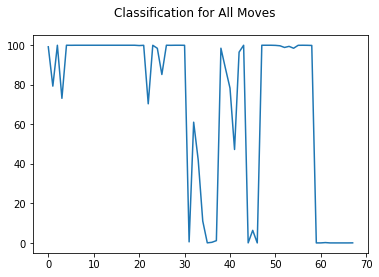

Average Rating:  71.07750642817102


In [274]:
plt.plot(range(0,len(all_recs)), all_recs)
plt.suptitle('Classification for All Moves')
plt.show()
print('Average Rating: ',np.mean(all_recs))

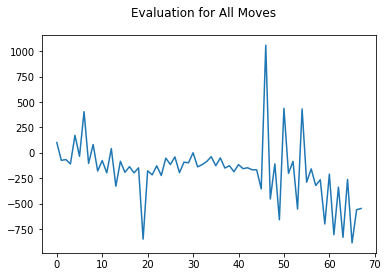

In [275]:
plt.plot(range(0,len(stock_both)), stock_both)
plt.suptitle('Evaluation for All Moves')
plt.show()

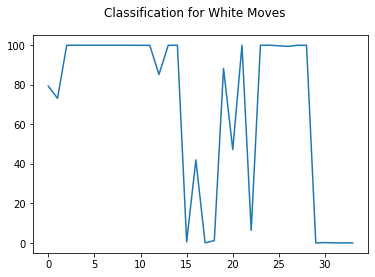

Average Rating:  68.30612747642253


In [276]:
plt.plot(range(0,len(white_recs)), white_recs)
plt.suptitle('Classification for White Moves')
plt.show()
print('Average Rating: ',np.mean(white_recs))

plt.plot(range(0,len(stock_white)), stock_white)
plt.suptitle('Evaluation for White Moves')
plt.show()

Average Rating:  73.84888537991952


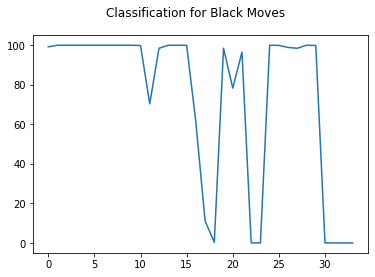

In [277]:
plt.plot(range(0,len(black_recs)), black_recs)
plt.suptitle('Classification for Black Moves')
print('Average Rating: ',np.mean(black_recs))

plt.plot(range(0,len(stock_black)), stock_black)
plt.suptitle('Evaluation for Black Moves')
plt.show()